In [39]:
#IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import joblib
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

In [40]:
# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [41]:
# 2. LOAD DATA

print("\n[1/10] Loading data...")
df = pd.read_csv('grocery_chain_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())


[1/10] Loading data...
Dataset shape: (1980, 11)
Columns: ['customer_id', 'store_name', 'transaction_date', 'aisle', 'product_name', 'quantity', 'unit_price', 'total_amount', 'discount_amount', 'final_amount', 'loyalty_points']

First few rows:
   customer_id         store_name transaction_date           aisle  \
0         2824  GreenGrocer Plaza       2023-08-26         Produce   
1         5506   ValuePlus Market       2024-02-13           Dairy   
2         4657   ValuePlus Market       2023-11-23          Bakery   
3         2679  SuperSave Central       2025-01-13  Snacks & Candy   
4         9935  GreenGrocer Plaza       2023-10-13    Canned Goods   

   product_name  quantity  unit_price  total_amount  discount_amount  \
0         Pasta       2.0        7.46         14.92             0.00   
1        Cheese       1.0        1.85          1.85             3.41   
2        Onions       4.0        7.38         29.52             4.04   
3        Cereal       3.0        5.50        

In [42]:
# 3. DATA PREPROCESSING

print("\n[2/10] Preprocessing data...")

# Convert transaction_date to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

# Remove rows with invalid dates
df = df.dropna(subset=['transaction_date'])

# Sort by date
df = df.sort_values('transaction_date').reset_index(drop=True)

print(f"✓ Date range: {df['transaction_date'].min().date()} to {df['transaction_date'].max().date()}")
print(f"✓ Total days: {(df['transaction_date'].max() - df['transaction_date'].min()).days + 1}")


[2/10] Preprocessing data...
✓ Date range: 2023-08-07 to 2025-08-05
✓ Total days: 730


In [43]:
# 4. AGGREGATE DAILY SALES

print("\n[3/10] Aggregating daily sales...")

# Aggregate sales by date, product, store
daily_sales = df.groupby(['transaction_date', 'product_name', 'store_name', 'aisle']).agg({
    'quantity': 'sum',
    'total_amount': 'sum',
    'customer_id': 'count'
}).reset_index()

daily_sales.rename(columns={'customer_id': 'num_transactions'}, inplace=True)

print(f"✓ Daily sales records: {len(daily_sales)}")
print(f"✓ Unique products: {daily_sales['product_name'].nunique()}")
print(f"✓ Unique stores: {daily_sales['store_name'].nunique()}")


[3/10] Aggregating daily sales...
✓ Daily sales records: 1952
✓ Unique products: 18
✓ Unique stores: 9


In [44]:
# 5. CREATE COMPLETE DATE RANGE (Fill Missing Days)


print("\n[4/10] Creating complete date range...")

# Get all unique product-store-aisle combinations
products = daily_sales[['product_name', 'store_name', 'aisle']].drop_duplicates()
date_range = pd.date_range(
    start=daily_sales['transaction_date'].min(),
    end=daily_sales['transaction_date'].max(),
    freq='D'
)

print(f" Date range: {len(date_range)} days")
print(f" Product-store combinations: {len(products)}")

# Create complete grid
complete_grid = []
for _, row in products.iterrows():
    for date in date_range:
        complete_grid.append({
            'transaction_date': date,
            'product_name': row['product_name'],
            'store_name': row['store_name'],
            'aisle': row['aisle']
        })

complete_df = pd.DataFrame(complete_grid)

# Merge with actual sales
daily_sales = complete_df.merge(
    daily_sales,
    on=['transaction_date', 'product_name', 'store_name', 'aisle'],
    how='left'
)

# Fill missing values with 0 (days with no sales)
daily_sales['quantity'] = daily_sales['quantity'].fillna(0)
daily_sales['total_amount'] = daily_sales['total_amount'].fillna(0)
daily_sales['num_transactions'] = daily_sales['num_transactions'].fillna(0)

# Sort
daily_sales = daily_sales.sort_values(
    ['product_name', 'store_name', 'transaction_date']
).reset_index(drop=True)

print(f" Complete dataset: {len(daily_sales)} records")


[4/10] Creating complete date range...
 Date range: 730 days
 Product-store combinations: 1179
 Complete dataset: 860670 records


In [45]:
# 6. FEATURE ENGINEERING

print("\n[5/10] Creating features...")

# Date features
daily_sales['day_of_week'] = daily_sales['transaction_date'].dt.dayofweek
daily_sales['day_of_month'] = daily_sales['transaction_date'].dt.day
daily_sales['week_of_year'] = daily_sales['transaction_date'].dt.isocalendar().week
daily_sales['month'] = daily_sales['transaction_date'].dt.month
daily_sales['is_weekend'] = daily_sales['day_of_week'].isin([5, 6]).astype(int)
daily_sales['is_month_start'] = daily_sales['transaction_date'].dt.is_month_start.astype(int)
daily_sales['is_month_end'] = daily_sales['transaction_date'].dt.is_month_end.astype(int)

print("✓ Date features added")

# Lag features (previous day and week)
print("✓ Creating lag features...")
daily_sales['quantity_lag_1'] = daily_sales.groupby(['product_name', 'store_name'])['quantity'].shift(1)
daily_sales['quantity_lag_7'] = daily_sales.groupby(['product_name', 'store_name'])['quantity'].shift(7)

# Rolling features (7-day and 14-day windows)
print("✓ Creating rolling features...")
for window in [7, 14]:
    # Mean
    daily_sales[f'quantity_rolling_mean_{window}'] = (
        daily_sales.groupby(['product_name', 'store_name'])['quantity']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
    )
    # Std
    daily_sales[f'quantity_rolling_std_{window}'] = (
        daily_sales.groupby(['product_name', 'store_name'])['quantity']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).std())
    )
    # Max
    daily_sales[f'quantity_rolling_max_{window}'] = (
        daily_sales.groupby(['product_name', 'store_name'])['quantity']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).max())
    )
    # Min
    daily_sales[f'quantity_rolling_min_{window}'] = (
        daily_sales.groupby(['product_name', 'store_name'])['quantity']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).min())
    )

# Fill NaN in rolling std with 0
daily_sales[f'quantity_rolling_std_7'] = daily_sales[f'quantity_rolling_std_7'].fillna(0)
daily_sales[f'quantity_rolling_std_14'] = daily_sales[f'quantity_rolling_std_14'].fillna(0)

print("✓ Rolling features added")

# Product and store statistics
print("✓ Creating aggregate features...")
product_stats = daily_sales.groupby('product_name')['quantity'].agg([
    ('product_avg_sales', 'mean'),
    ('product_std_sales', 'std'),
    ('product_max_sales', 'max'),
    ('product_min_sales', 'min')
]).reset_index()
product_stats['product_std_sales'] = product_stats['product_std_sales'].fillna(0)

store_stats = daily_sales.groupby('store_name')['quantity'].agg([
    ('store_avg_sales', 'mean'),
    ('store_std_sales', 'std')
]).reset_index()
store_stats['store_std_sales'] = store_stats['store_std_sales'].fillna(0)

daily_sales = daily_sales.merge(product_stats, on='product_name', how='left')
daily_sales = daily_sales.merge(store_stats, on='store_name', how='left')

print("✓ Aggregate features added")

# Encode categorical variables
print("✓ Encoding categories...")
le_product = LabelEncoder()
le_store = LabelEncoder()
le_aisle = LabelEncoder()

daily_sales['product_encoded'] = le_product.fit_transform(daily_sales['product_name'])
daily_sales['store_encoded'] = le_store.fit_transform(daily_sales['store_name'])
daily_sales['aisle_encoded'] = le_aisle.fit_transform(daily_sales['aisle'])

print(f"✓ Total features created: {daily_sales.shape[1]}")


[5/10] Creating features...
✓ Date features added
✓ Creating lag features...
✓ Creating rolling features...
✓ Rolling features added
✓ Creating aggregate features...
✓ Aggregate features added
✓ Encoding categories...
✓ Total features created: 33


In [46]:
# 7. PREPARE MODEL DATA

print("\n[6/10] Preparing model data...")

# Define feature columns
feature_cols = [
    # Encoded categorical features
    'product_encoded', 'store_encoded', 'aisle_encoded',

    # Date features
    'day_of_week', 'day_of_month', 'week_of_year', 'month',
    'is_weekend', 'is_month_start', 'is_month_end',

    # Lag features
    'quantity_lag_1', 'quantity_lag_7',

    # Rolling features
    'quantity_rolling_mean_7', 'quantity_rolling_std_7',
    'quantity_rolling_max_7', 'quantity_rolling_min_7',
    'quantity_rolling_mean_14', 'quantity_rolling_std_14',
    'quantity_rolling_max_14', 'quantity_rolling_min_14',

    # Aggregate features
    'product_avg_sales', 'product_std_sales',
    'store_avg_sales', 'store_std_sales',

    # Transaction features
    'num_transactions', 'total_amount'
]

target_col = 'quantity'

# Handle missing values
print(f"Rows before handling NaN: {len(daily_sales)}")
model_data = daily_sales.copy()

# Fill remaining NaN values with forward fill, then 0
lag_cols = [col for col in feature_cols if 'lag' in col or 'rolling' in col]
for col in lag_cols:
    model_data[col] = model_data.groupby(['product_name', 'store_name'])[col].fillna(method='ffill')
model_data[feature_cols] = model_data[feature_cols].fillna(0)

print(f"Rows after handling NaN: {len(model_data)}")

# Prepare X and y
X = model_data[feature_cols]
y = model_data[target_col]

if len(X) < 10:
    raise ValueError(f"Insufficient data: {len(X)} samples. Need at least 10 samples.")

print(f"✓ Features: {len(feature_cols)}")
print(f"✓ Samples: {len(X):,}")



[6/10] Preparing model data...
Rows before handling NaN: 860670
Rows after handling NaN: 860670
✓ Features: 26
✓ Samples: 860,670


In [47]:
# 8. TRAIN-TEST SPLIT (Time-based)

print("\n[7/10] Splitting data (time-based)...")

# Use last 20% as test set
split_date = model_data['transaction_date'].quantile(0.8)

train_mask = model_data['transaction_date'] < split_date
test_mask = model_data['transaction_date'] >= split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"✓ Training set: {len(X_train):,} samples")
print(f"✓ Test set: {len(X_test):,} samples")
print(f"✓ Split date: {split_date.date()}")


[7/10] Splitting data (time-based)...
✓ Training set: 688,536 samples
✓ Test set: 172,134 samples
✓ Split date: 2025-03-12


In [48]:
# 9. TRAIN XGBOOST MODEL

print("\n[8/10] Training XGBoost model...")

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_model.fit(X_train, y_train)
print("✓ Model training completed")


[8/10] Training XGBoost model...
✓ Model training completed



[9/10] Evaluating model performance...

Training set Performance:
MAE           : 0.001
RMSE          : 0.021
R²            : 0.981
MAPE          : 16.30%
Mean target   : 0.01
Mean prediction: 0.01

Test set      Performance:
MAE           : 0.002
RMSE          : 0.056
R²            : 0.878
MAPE          : 41.93%
Mean target   : 0.01
Mean prediction: 0.01


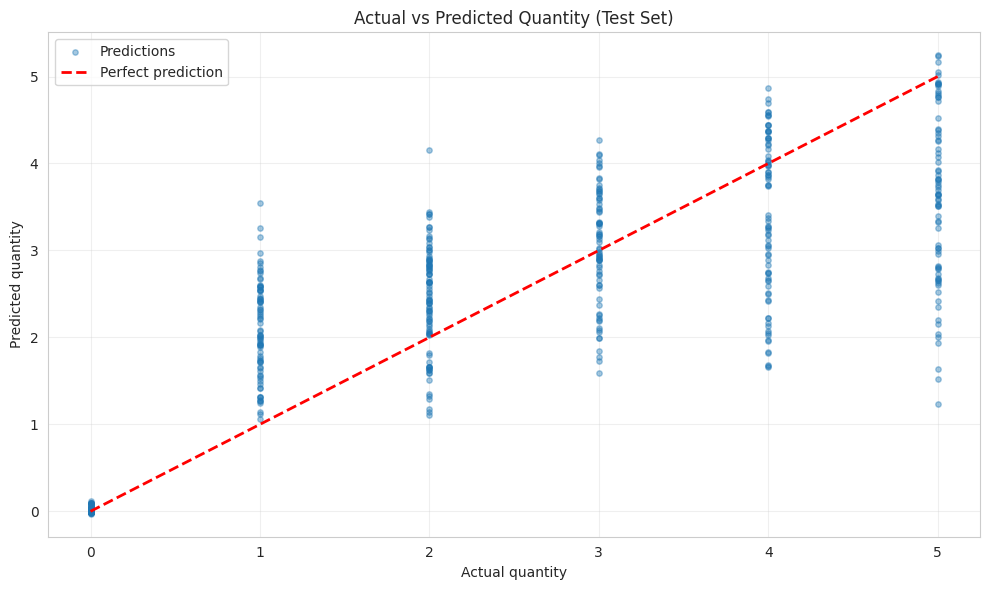


Top 15 most important features:


,feature,importance
24,num_transactions,0.7726
25,total_amount,0.1518
7,is_weekend,0.0065
23,store_std_sales,0.0064
0,product_encoded,0.0060
5,week_of_year,0.0059
6,month,0.0058
3,day_of_week,0.0058
22,store_avg_sales,0.0056
4,day_of_month,0.0054


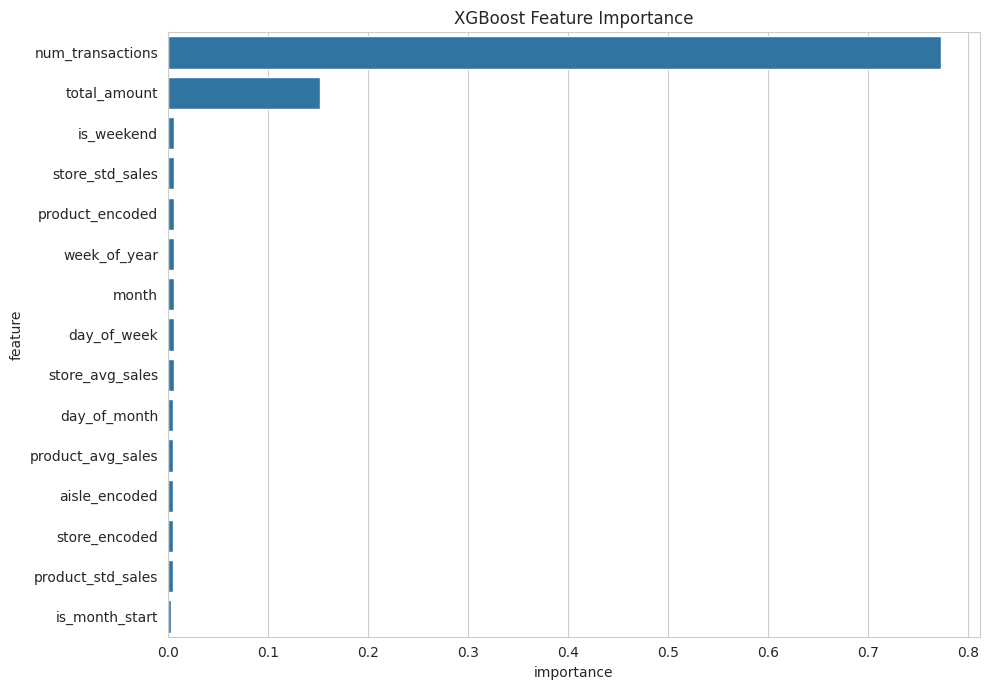

In [49]:
# 10. EVALUATE THE MODEL

print("\n[9/10] Evaluating model performance...")

# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test  = xgb_model.predict(X_test)

# ────────────────────────────────────────────────
# Helper function for nicer metric printing
# ────────────────────────────────────────────────
def print_regression_metrics(y_true, y_pred, dataset_name="Dataset"):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    # Mean Absolute Percentage Error (MAPE) — avoid division by zero
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.nan

    print(f"\n{dataset_name} Performance:")
    print(f"MAE           : {mae:,.3f}")
    print(f"RMSE          : {rmse:,.3f}")
    print(f"R²            : {r2:,.3f}")
    print(f"MAPE          : {mape:,.2f}%")
    print(f"Mean target   : {y_true.mean():,.2f}")
    print(f"Mean prediction: {y_pred.mean():,.2f}")

# ────────────────────────────────────────────────
# Print results
# ────────────────────────────────────────────────
print_regression_metrics(y_train, y_pred_train, "Training set")
print_regression_metrics(y_test,  y_pred_test,  "Test set     ")

# ────────────────────────────────────────────────
# Optional: Plot actual vs predicted (test set)
# ────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.4, s=15, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label="Perfect prediction")
plt.xlabel("Actual quantity")
plt.ylabel("Predicted quantity")
plt.title("Actual vs Predicted Quantity (Test Set)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────
# Feature importance (top 15)
# ────────────────────────────────────────────────
print("\nTop 15 most important features:")
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

display(importance.round(4))

# Optional: bar plot
plt.figure(figsize=(10, 7))
sns.barplot(x='importance', y='feature', data=importance)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

In [55]:
print("\n[10/10] Advanced evaluation & visualisations...")

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.metrics import explained_variance_score
# Predictions
y_pred = xgb_model.predict(X_test)

# =============================
# 📊 METRICS
# =============================
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
smape = 100/len(y_test) * np.sum(
    2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred))
)

print("\n📊 Model Metrics")
print("----------------------")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.3f}")
print(f"SMAPE: {smape:.2f}%")
print(f"EVS  : {evs:.3f}")  # Explained Variance Score




[10/10] Advanced evaluation & visualisations...

📊 Model Metrics
----------------------
MAE  : 0.00
RMSE : 0.06
R²   : 0.878
SMAPE: 199.61%
EVS  : 0.878


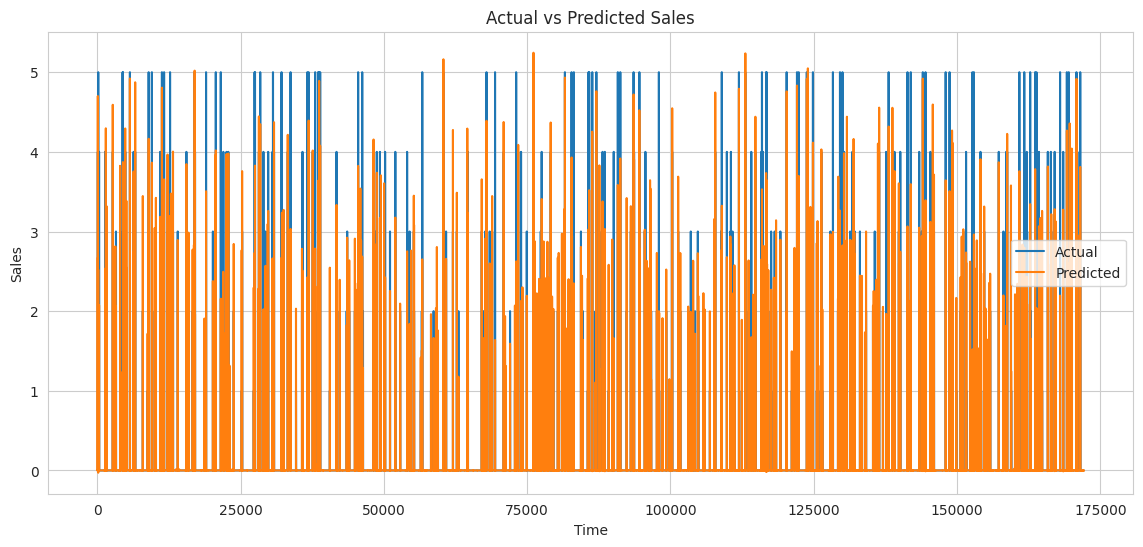

In [53]:
plt.figure(figsize=(14,6))

plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")

plt.title("Actual vs Predicted Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


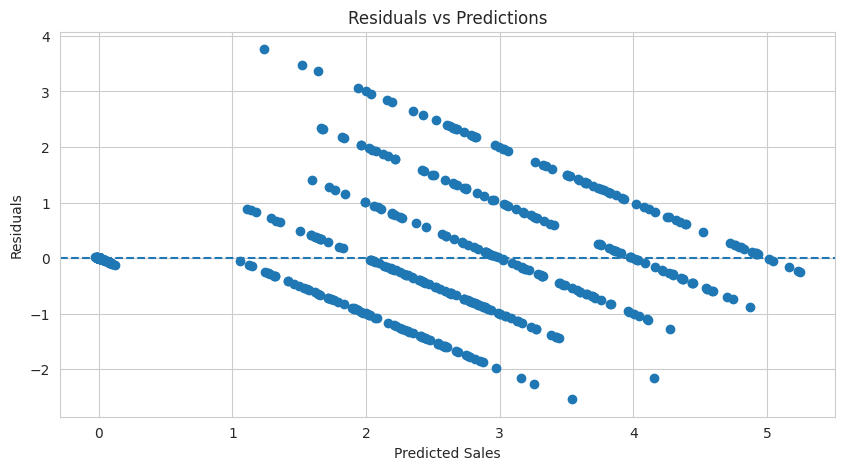

In [54]:
residuals = y_test - y_pred

plt.figure(figsize=(10,5))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, linestyle='--')
plt.title("Residuals vs Predictions")
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()
